In [1]:
!pip install efficientnet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

# Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 4098 images belonging to 4 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.63it/s]


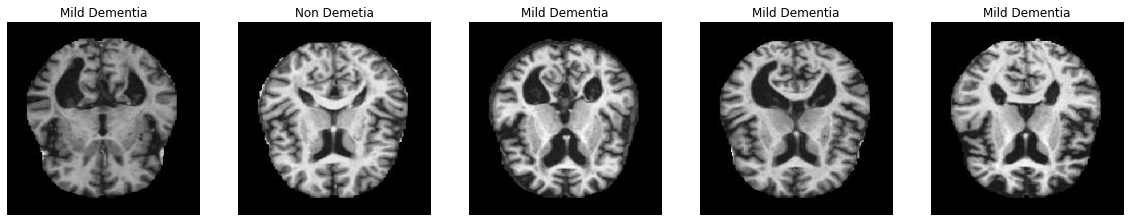

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [7]:
base_model = enet.EfficientNetB0(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

In [8]:
for layer in base_model.layers:
    layer.trainable=False

In [9]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 1280)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 1280)        5120      
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11520)             46080     
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [11]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [12]:
filepath = './model_tuning224_128_Adam1e3.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [13]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                         
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.3435 - auc: 0.7015
Epoch 00001: val_auc improved from -inf to 0.62287, saving model to .\model_tuning224_128_Adam1e3.h5
65/65 [==============================] - 160s 2s/step - loss: 1.3435 - auc: 0.7015 - val_loss: 1.3383 - val_auc: 0.6229
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.9825 - auc: 0.8308
Epoch 00002: val_auc improved from 0.62287 to 0.70000, saving model to .\model_tuning224_128_Adam1e3.h5
65/65 [==============================] - 153s 2s/step - loss: 0.9825 - auc: 0.8308 - val_loss: 1.1887 - val_auc: 0.7000
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.8769 - auc: 0.8646
Epoch 00003: val_auc improved from 0.70000 to 0.72480, saving model to .\model_tuning224_128_Adam1e3.h5
65/65 [==============================] - 161s 2s/step - loss: 0.8769 - auc: 0.8646 - val_loss: 1.1435 - val_auc: 0.7248
Epoch 4/100
65/65 [==============================] - ETA: 0s 

Epoch 30/100
65/65 [==============================] - ETA: 0s - loss: 0.3721 - auc: 0.9749
Epoch 00030: val_auc improved from 0.90243 to 0.90532, saving model to .\model_tuning224_128_Adam1e3.h5
65/65 [==============================] - 175s 3s/step - loss: 0.3721 - auc: 0.9749 - val_loss: 0.7558 - val_auc: 0.9053
Epoch 31/100
65/65 [==============================] - ETA: 0s - loss: 0.3574 - auc: 0.9767
Epoch 00031: val_auc did not improve from 0.90532
65/65 [==============================] - 179s 3s/step - loss: 0.3574 - auc: 0.9767 - val_loss: 0.7675 - val_auc: 0.9037
Epoch 32/100
65/65 [==============================] - ETA: 0s - loss: 0.3461 - auc: 0.9781
Epoch 00032: val_auc did not improve from 0.90532
65/65 [==============================] - 158s 2s/step - loss: 0.3461 - auc: 0.9781 - val_loss: 0.8525 - val_auc: 0.8871
Epoch 33/100
65/65 [==============================] - ETA: 0s - loss: 0.3569 - auc: 0.9766
Epoch 00033: val_auc improved from 0.90532 to 0.90678, saving model to .

65/65 [==============================] - ETA: 0s - loss: 0.2829 - auc: 0.9845
Epoch 00059: val_auc did not improve from 0.93665
65/65 [==============================] - 161s 2s/step - loss: 0.2829 - auc: 0.9845 - val_loss: 0.8081 - val_auc: 0.9055
Epoch 60/100
65/65 [==============================] - ETA: 0s - loss: 0.2702 - auc: 0.9860
Epoch 00060: val_auc did not improve from 0.93665
65/65 [==============================] - 161s 2s/step - loss: 0.2702 - auc: 0.9860 - val_loss: 0.7247 - val_auc: 0.9181
Epoch 61/100
65/65 [==============================] - ETA: 0s - loss: 0.2437 - auc: 0.9891
Epoch 00061: val_auc did not improve from 0.93665
65/65 [==============================] - 162s 2s/step - loss: 0.2437 - auc: 0.9891 - val_loss: 0.6573 - val_auc: 0.9303
Epoch 62/100
65/65 [==============================] - ETA: 0s - loss: 0.2652 - auc: 0.9868
Epoch 00062: val_auc did not improve from 0.93665
65/65 [==============================] - 156s 2s/step - loss: 0.2652 - auc: 0.9868 - val_

Epoch 90/100
65/65 [==============================] - ETA: 0s - loss: 0.2132 - auc: 0.9905
Epoch 00090: val_auc did not improve from 0.94432
65/65 [==============================] - 153s 2s/step - loss: 0.2132 - auc: 0.9905 - val_loss: 0.5959 - val_auc: 0.9437
Epoch 91/100
65/65 [==============================] - ETA: 0s - loss: 0.2062 - auc: 0.9918
Epoch 00091: val_auc did not improve from 0.94432
65/65 [==============================] - 158s 2s/step - loss: 0.2062 - auc: 0.9918 - val_loss: 0.6255 - val_auc: 0.9391
Epoch 92/100
65/65 [==============================] - ETA: 0s - loss: 0.2092 - auc: 0.9913
Epoch 00092: val_auc did not improve from 0.94432
65/65 [==============================] - 155s 2s/step - loss: 0.2092 - auc: 0.9913 - val_loss: 0.5965 - val_auc: 0.9437
Epoch 93/100
65/65 [==============================] - ETA: 0s - loss: 0.2061 - auc: 0.9915
Epoch 00093: val_auc did not improve from 0.94432
65/65 [==============================] - 155s 2s/step - loss: 0.2061 - auc: 

In [14]:
  base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

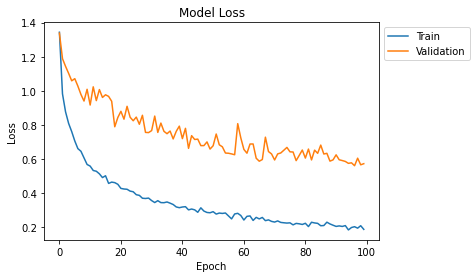

In [15]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

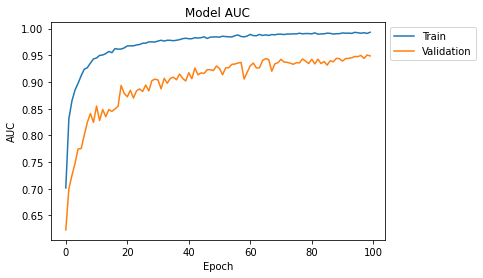

In [16]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

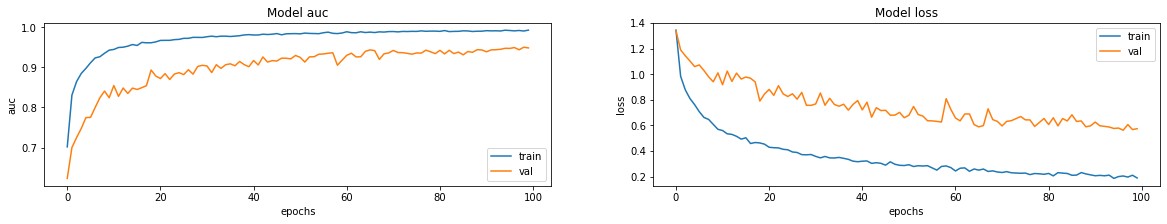

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64)

Found 1279 images belonging to 4 classes.


In [19]:
model.evaluate(test_dataset)

20/20 [==============================] - 33s 2s/step - loss: 0.9212 - auc: 0.9131


[0.9211700558662415, 0.9131227731704712]

In [20]:
true_classes=test_dataset.classes
true_classes

array([0, 0, 0, ..., 3, 3, 3])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
99.69 % chances are there that the image is NonDemented


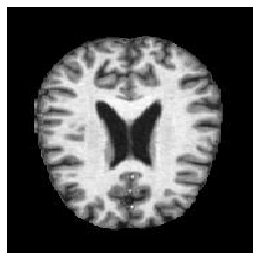

In [21]:
# Test Case 1: Non-Dementia

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

90.47 % chances are there that the image is MildDemented


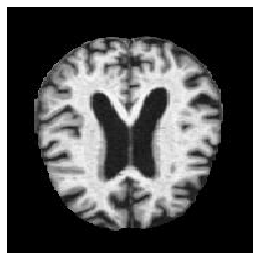

In [22]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.33 % chances are there that the image is ModerateDemented


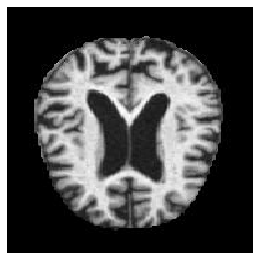

In [23]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.75 % chances are there that the image is VeryMildDemented


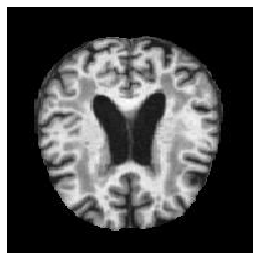

In [24]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])